In [1]:
# filter(x -> occursin("SLURM", x), keys(ENV))
#ENV["SLURM_NNODES"]
#parse(Int, ENV["SLURM_JOB_CPUS_PER_NODE"])
pwd()

"/Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration"

In [178]:
# activate environment
using Pkg; Pkg.activate(".")

import ClimaAtmos as CA
import ClimaAnalysis: SimDir, get, slice, average_xy
using CairoMakie
import JLD2
import LinearAlgebra: I
import EnsembleKalmanProcesses as EKP
import Statistics: var, mean
using Test
using Revise
using LinearAlgebra: Diagonal
using ClimaCalibrate

# include("observation_map.jl")

# using Revise
# import ClimaCalibrate as CAL
# import ClimaAtmos as CA
# experiment_dir = joinpath(pkgdir(CA), "calibration", "experiments", "gcm_driven_scm")
# model_interface =
#     joinpath(pkgdir(CA), "calibration", "model_interface.jl")
# output_dir = joinpath("output", "gcm_driven_scm")
# # include model interface
# includet(model_interface)
# obs_path = joinpath(experiment_dir, "observations.jld2")


  Activating project at `~/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration`


## Calibration Evaluation and Setup

In [3]:
observations = JLD2.load_object(obs_path)
noise = 0.1 * I
n_iterations = 3
ensemble_size = 9
prior = CAL.get_prior(joinpath(experiment_dir, "prior.toml"))
experiment_config = CAL.ExperimentConfig(;
    n_iterations,
    ensemble_size,
    observations,
    noise,
    output_dir,
    prior,
)

InterruptException: InterruptException:

In [11]:
obs_path = joinpath(experiment_dir, "observations.jld2")
observations = JLD2.load_object(obs_path)
observations

1-element Vector{Float64}:
 285.0

In [ ]:
@everywhere begin
    using JLD2
    experiment_dir = dirname(Base.active_project())
    obs_path = joinpath(experiment_dir, "observations.jld2")
    if !isfile(obs_path)
        error("Observation file not found at: $obs_path")
    else
        println("Worker ", myid(), " can access the observations file.")
    end
end

In [ ]:
reshape(G_ens[1,:], 1, 10)
EKP.update_ensemble!(eki, reshape(G_ens[1,:], 1, 10))
CAL.save_eki_state(eki, output_dir, 1, prior)

## Visualization

In [4]:
# imports 
import EnsembleKalmanProcesses as EKP
using EnsembleKalmanProcesses.ParameterDistributions
using EnsembleKalmanProcesses.TOMLInterface
using Distributions
import Statistics: mean
import CairoMakie: Makie
import ClimaCalibrate

In [19]:
function convergence_plot(
    eki::EKP.EnsembleKalmanProcess,
    prior::ParameterDistribution;
    theta_star = 65.0,
    output = joinpath("output", "sphere_held_suarez_rhoe_equilmoist"),
)
    u_vec = EKP.get_u(eki)
    meanabsdiff²(x, e) = sum(i -> abs(i - x)^2, e) / length(e)
    error_vec = map(ensemble -> meanabsdiff²(theta_star, ensemble), u_vec)
    spread_vec = map(ensemble -> meanabsdiff²(mean(ensemble), ensemble), u_vec)
    phi_vec = transform_unconstrained_to_constrained(prior, u_vec)
    u_series = eachcol(reduce(vcat, u_vec))
    phi_series = eachcol(reduce(vcat, phi_vec))

    f = Makie.Figure(title = "Convergence Plot", resolution = (800, 800))

    ax = Makie.Axis(
        f[1, 1],
        xlabel = "Iteration",
        ylabel = "Error",
        xticks = 0:50,
    )
    Makie.lines!(ax, 0.0:(length(error_vec) - 1), error_vec)

    ax = Makie.Axis(
        f[1, 2],
        xlabel = "Iteration",
        ylabel = "Spread",
        xticks = 0:50,
    )
    Makie.lines!(ax, 0.0:(length(spread_vec) - 1), spread_vec)

    ax = Makie.Axis(
        f[2, 1],
        xlabel = "Iteration",
        ylabel = "Unconstrained Parameters",
        xticks = 0:50,
    )
    Makie.lines!.(ax, tuple(0.0:(length(u_series[1]) - 1)), u_series)

    ax = Makie.Axis(
        f[2, 2],
        xlabel = "Iteration",
        ylabel = "Constrained Parameters",
        xticks = 0:50,
    )
    Makie.lines!.(ax, tuple(0.0:(length(phi_series[1]) - 1)), phi_series)
    #Makie.hlines!(ax, [theta_star], color = :red, linestyle = :dash)
    Makie.save(joinpath(output, "convergence.png"), f)
end

function scatter_plot(
    eki,
    output = joinpath("output", "sphere_held_suarez_rhoe_equilmoist"),
)
    # Define figure with explicit size
    f = Makie.Figure(resolution = (800, 600))
    a = Makie.Axis(
        f[1, 1],
        title = "60-Day Zonal Avg Temp at 242m versus Unconstrained Equator-Pole Temp Gradient",
        ylabel = "Parameter Value",
        xlabel = "Temperature (K)",
    )

    g = vec.(EKP.get_g(eki; return_array = true))
    u = vec.(EKP.get_u(eki; return_array = true))

    for (gg, uu) in zip(g, u)
        Makie.scatter!(a, gg, uu)
    end

    # Save the figure
    Makie.save(joinpath(output, "scatter.png"), f)
end

scatter_plot (generic function with 2 methods)

In [188]:
println(pwd())
println(output_dir)
readdir(output_dir)

/Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration
output/local_calibration


6-element Vector{String}:
 "iteration_000"
 "iteration_001"
 "iteration_002"
 "iteration_003"
 "output_0000"
 "output_active"

In [179]:
import JLD2
iteration = 3
output_dir = joinpath("output", "local_calibration")
eki_filepath = joinpath(ClimaCalibrate.path_to_iteration(output_dir, iteration), "eki_file.jld2")
eki = JLD2.load_object(eki_filepath)
prior_path = joinpath("prior.toml")
prior = ClimaCalibrate.get_prior(prior_path)


ParameterDistribution with 5 entries: 
'mixing_length_eddy_viscosity_coefficient' with EnsembleKalmanProcesses.ParameterDistributions.Constraint{EnsembleKalmanProcesses.ParameterDistributions.BoundedBelow}[Bounds: (0.0, ∞)] over distribution EnsembleKalmanProcesses.ParameterDistributions.Parameterized(Distributions.Normal{Float64}(μ=-1.9686573911265683, σ=0.07133771448169109)) 
'detr_massflux_vertdiv_coeff' with EnsembleKalmanProcesses.ParameterDistributions.Constraint{EnsembleKalmanProcesses.ParameterDistributions.BoundedBelow}[Bounds: (0.0, ∞)] over distribution EnsembleKalmanProcesses.ParameterDistributions.Parameterized(Distributions.Normal{Float64}(μ=0.13599544622138604, σ=0.0867928125339026)) 
'entr_coeff' with EnsembleKalmanProcesses.ParameterDistributions.Constraint{EnsembleKalmanProcesses.ParameterDistributions.BoundedBelow}[Bounds: (0.0, ∞)] over distribution EnsembleKalmanProcesses.ParameterDistributions.Parameterized(Distributions.Normal{Float64}(μ=-1.20894796975252, σ=0.09

In [197]:
eki.Δt

3-element Vector{Float64}:
 1.0
 1.0
 1.0

In [180]:
size(vcat(EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))...), 2)

15

In [184]:
names = EKP.get_name(prior)

# get parameter data and put in matrix form 
params = EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))
params = EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))
params = vcat(params...)
params = reshape(params, length(names), eki.N_ens, iteration+1)
params = permutedims(params, (3, 1, 2));

In [195]:
mean(params[:, 3, :], dims = 2)

4×1 Matrix{Float64}:
 0.31964682386356474
 0.3242061503014669
 0.30041982502036385
 0.3045862340378028

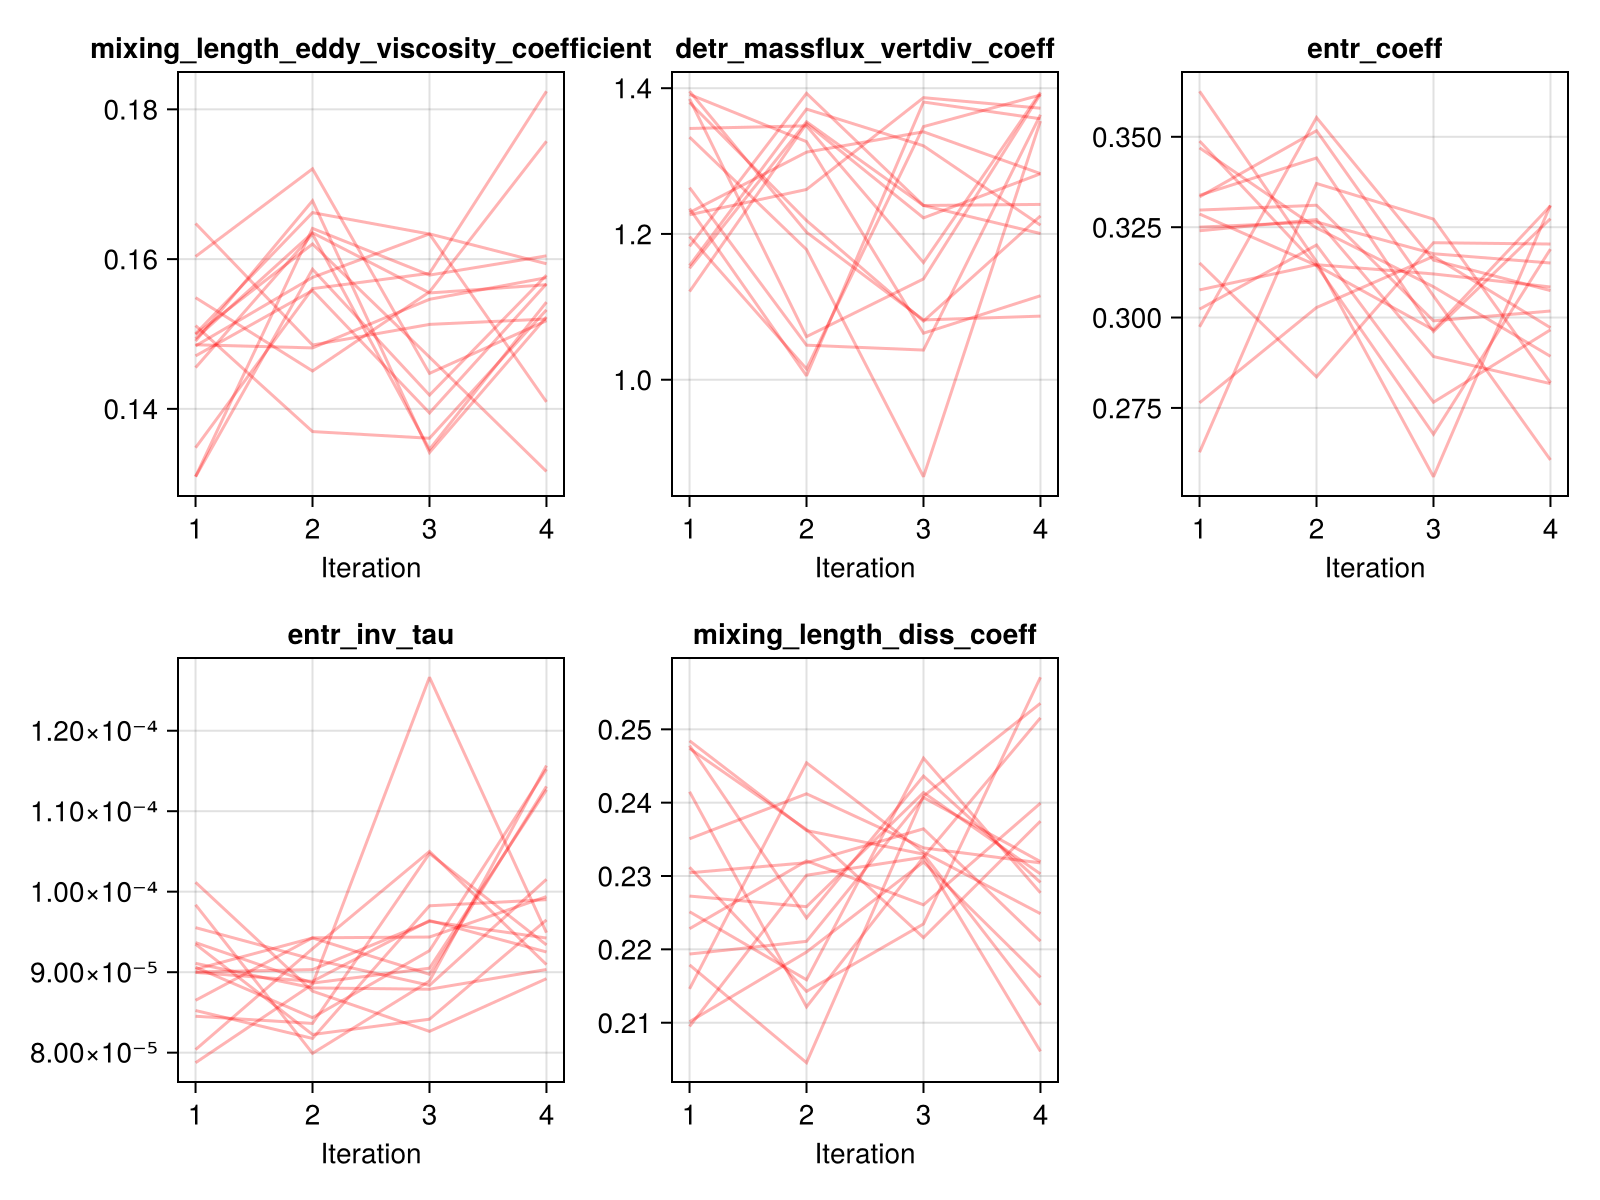

In [185]:
fig = Figure(size = (800, 600))

num_per_row = 3
for i in 1:length(names)
    row = div(i-1, num_per_row) + 1
    col = mod(i-1, num_per_row) + 1
    
    ax = Axis(fig[row, col], title = names[i], xlabel = "Iteration")
    
    for j in 1:size(params, 3)
        lines!(ax, 1:size(params, 1), params[:, i, j], color = :red, alpha = 0.3)
    end
end
fig

In [15]:
# create a similar plot but show the loss function value (e.g., rlut) instead of the parameter value
fieldnames(EKP.EnsembleKalmanProcess)

(:u, :observation_series, :N_ens, :g, :err, :scheduler, :accelerator, :Δt, :process, :rng, :failure_handler, :localizer, :verbose)

In [80]:
mean(loss_vals[1,:][(!).(isnan.(loss_vals[1, :]))])

276.5868225097656

In [87]:
function mean_ignore_nan(arr, dim)
    mean_values = mapslices(x -> mean(x[(!).(isnan.(x))]), arr, dims=dim)
    return vec(mean_values)
end

mean_ignore_nan(loss_vals, 2)

5-element Vector{Float64}:
 276.5868225097656
 276.3648173014323
 275.94365844726565
 275.67548217773435
 275.2759053548177

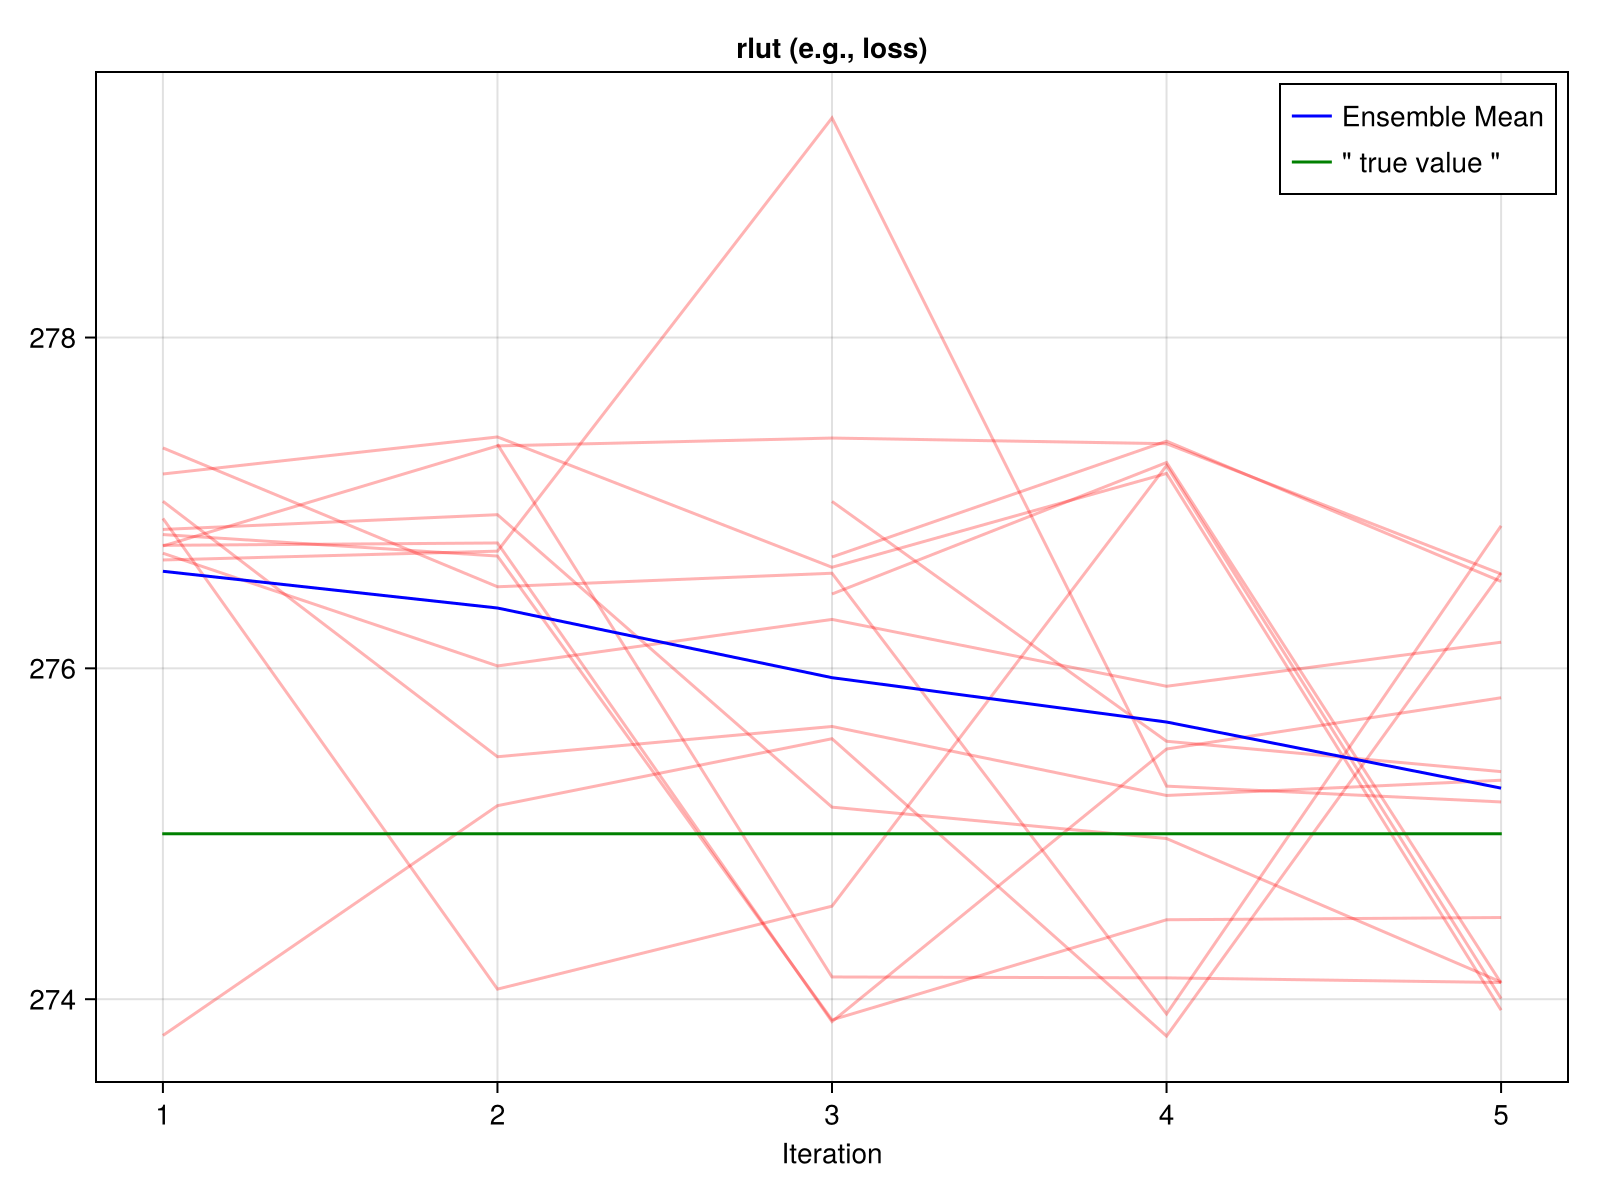

In [107]:
loss_vals = vcat(EKP.get_g(eki)...)

fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], title = "rlut (e.g., loss)", xlabel = "Iteration")
for i in 1:size(loss_vals, 2)
    lines!(ax, 1:size(loss_vals, 1), loss_vals[:, i], color = :red, alpha = 0.3)
end
lines!(ax, 1:size(loss_vals, 1), mean_ignore_nan(loss_vals, 2), color = :blue, label = "Ensemble Mean")
hlines!(ax, [275], xmin = .045, xmax= .955, color = :green, label = "\" true value \"")
# legend = Legend(fig, ax, tellwidth = false, tellheight = false)
# fig[1, 2] = legend
axislegend(ax, position = :rt)
fig
# size(loss_vals, 1)
# loss_vals[1][:]

# reshape loss_vals to be matrix 
# size(loss_vals)

In [145]:
# generate some plots of all variables for different simulations
# argmin(abs.(loss_vals .- 275))
best = argmin(replace(abs.(loss_vals .-275), NaN => Inf))
worst = argmax(replace(abs.(loss_vals .-275), NaN => -Inf))

println("Best: ", best, loss_vals[best])
println("Worst: ", worst, loss_vals[worst])


Best: CartesianIndex(4, 3)274.9712219238281
Worst: CartesianIndex(3, 6)279.3276062011719


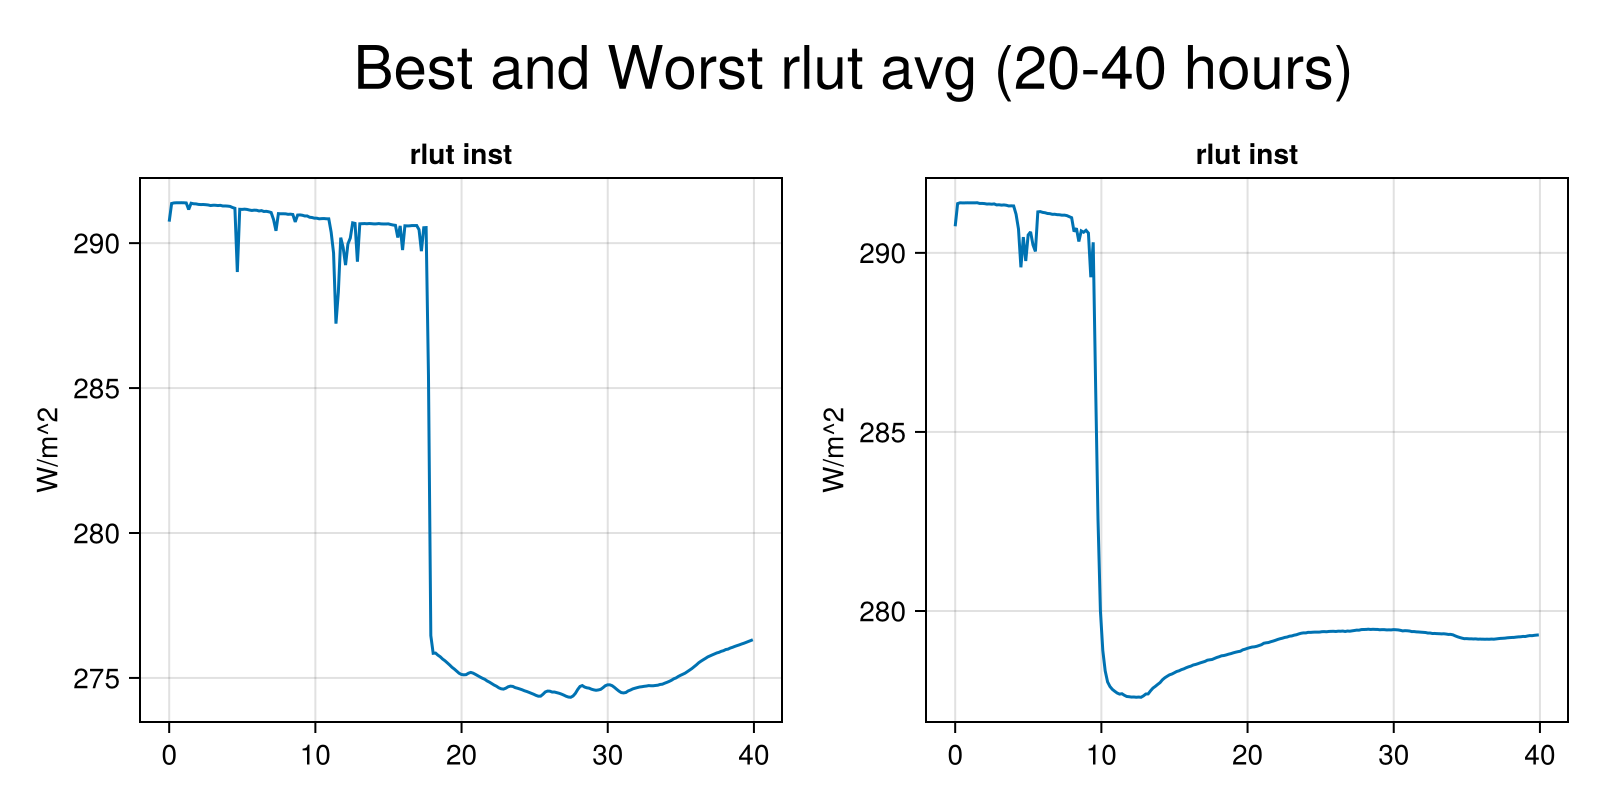

In [149]:
fig = Figure(size = (800, 400))
min_simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_003", "member_003","output_active"))
max_simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_002", "member_006","output_active"))

add_var(fig, "rlut", min_simdir, 1, 1, lines = true)
add_var(fig, "rlut", max_simdir, 1, 2, lines = true)
supertitle = Label(fig[0, :], "Best and Worst rlut avg (20-40 hours)", fontsize = 30)

fig

In [3]:
#simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_004", "member_001","output_active"))
# println(summary(simdir))

function add_var(fig, var, simdir = simdir, col = 1, ind = 1; lines = false, reduction = "inst")
    # get data 
    da = get(simdir; short_name = var, reduction = "inst")
    title = "$var $reduction"
    if lines
        ax = Axis(fig[col, ind], ylabel = "W/m^2", title = title)
        ln = lines!(da.dims["time"]/ 21600*6, da.data[:, 1, 1])
       # Colorbar(fig[col, ind+1], ln, label = var)
    elseif var == "wa"
        ax = Axis(fig[col, ind][1, 1], ylabel = "height (km)", xlabel="time (hrs)", title = title)
        hm = heatmap!(da.dims["time"][1:end]/ 21600*6, 
                      da.dims["z"][1:20]/1000,
                      da.data[1:end, 1, 1, 1:20])
        Colorbar(fig[col, ind][1,2], hm)
    else
        ax = Axis(fig[col, ind][1, 1], ylabel = "height (km)", xlabel="time (hrs)", title = title)
        hm = heatmap!(da.dims["time"]/ 21600*6, 
                      da.dims["z"][1:20]/1000,
                      da.data[:, 1, 1, 1:20])
        Colorbar(fig[col, ind][1,2], hm)
    end
end

function plot_defaults(dirname)
    simdir = SimDir(dirname)

    fig = Figure(size=(1400,800))

    vars = ["clw", "wa", "entr", "hus", "rlut", "rlutcs", "rsut", "rsutcs", "waup", "tke"]
    for (ind, var) in enumerate(["ta", "wa", "clw", "cl", "rlut", "rlutcs", "rsut", "rsutcs", "waup", "tke", "arup", "entr", "detr"])
        if var in ["rlut", "rlutcs", "rsut", "rsutcs"] # add lines
            add_var(fig, var, simdir, ind % 4 + 1, div(ind, 4) + 1, lines = true)
        else
            add_var(fig, var, simdir, ind % 4 + 1, div(ind, 4) + 1)
        end
    end
    add_var(fig, "tke", simdir, 1, 1, lines = false, reduction = "max")

    fig 
end

plot_defaults(joinpath("output", "gcm_driven_scm", "iteration_003", "member_003","output_active"))

plot_defaults (generic function with 1 method)

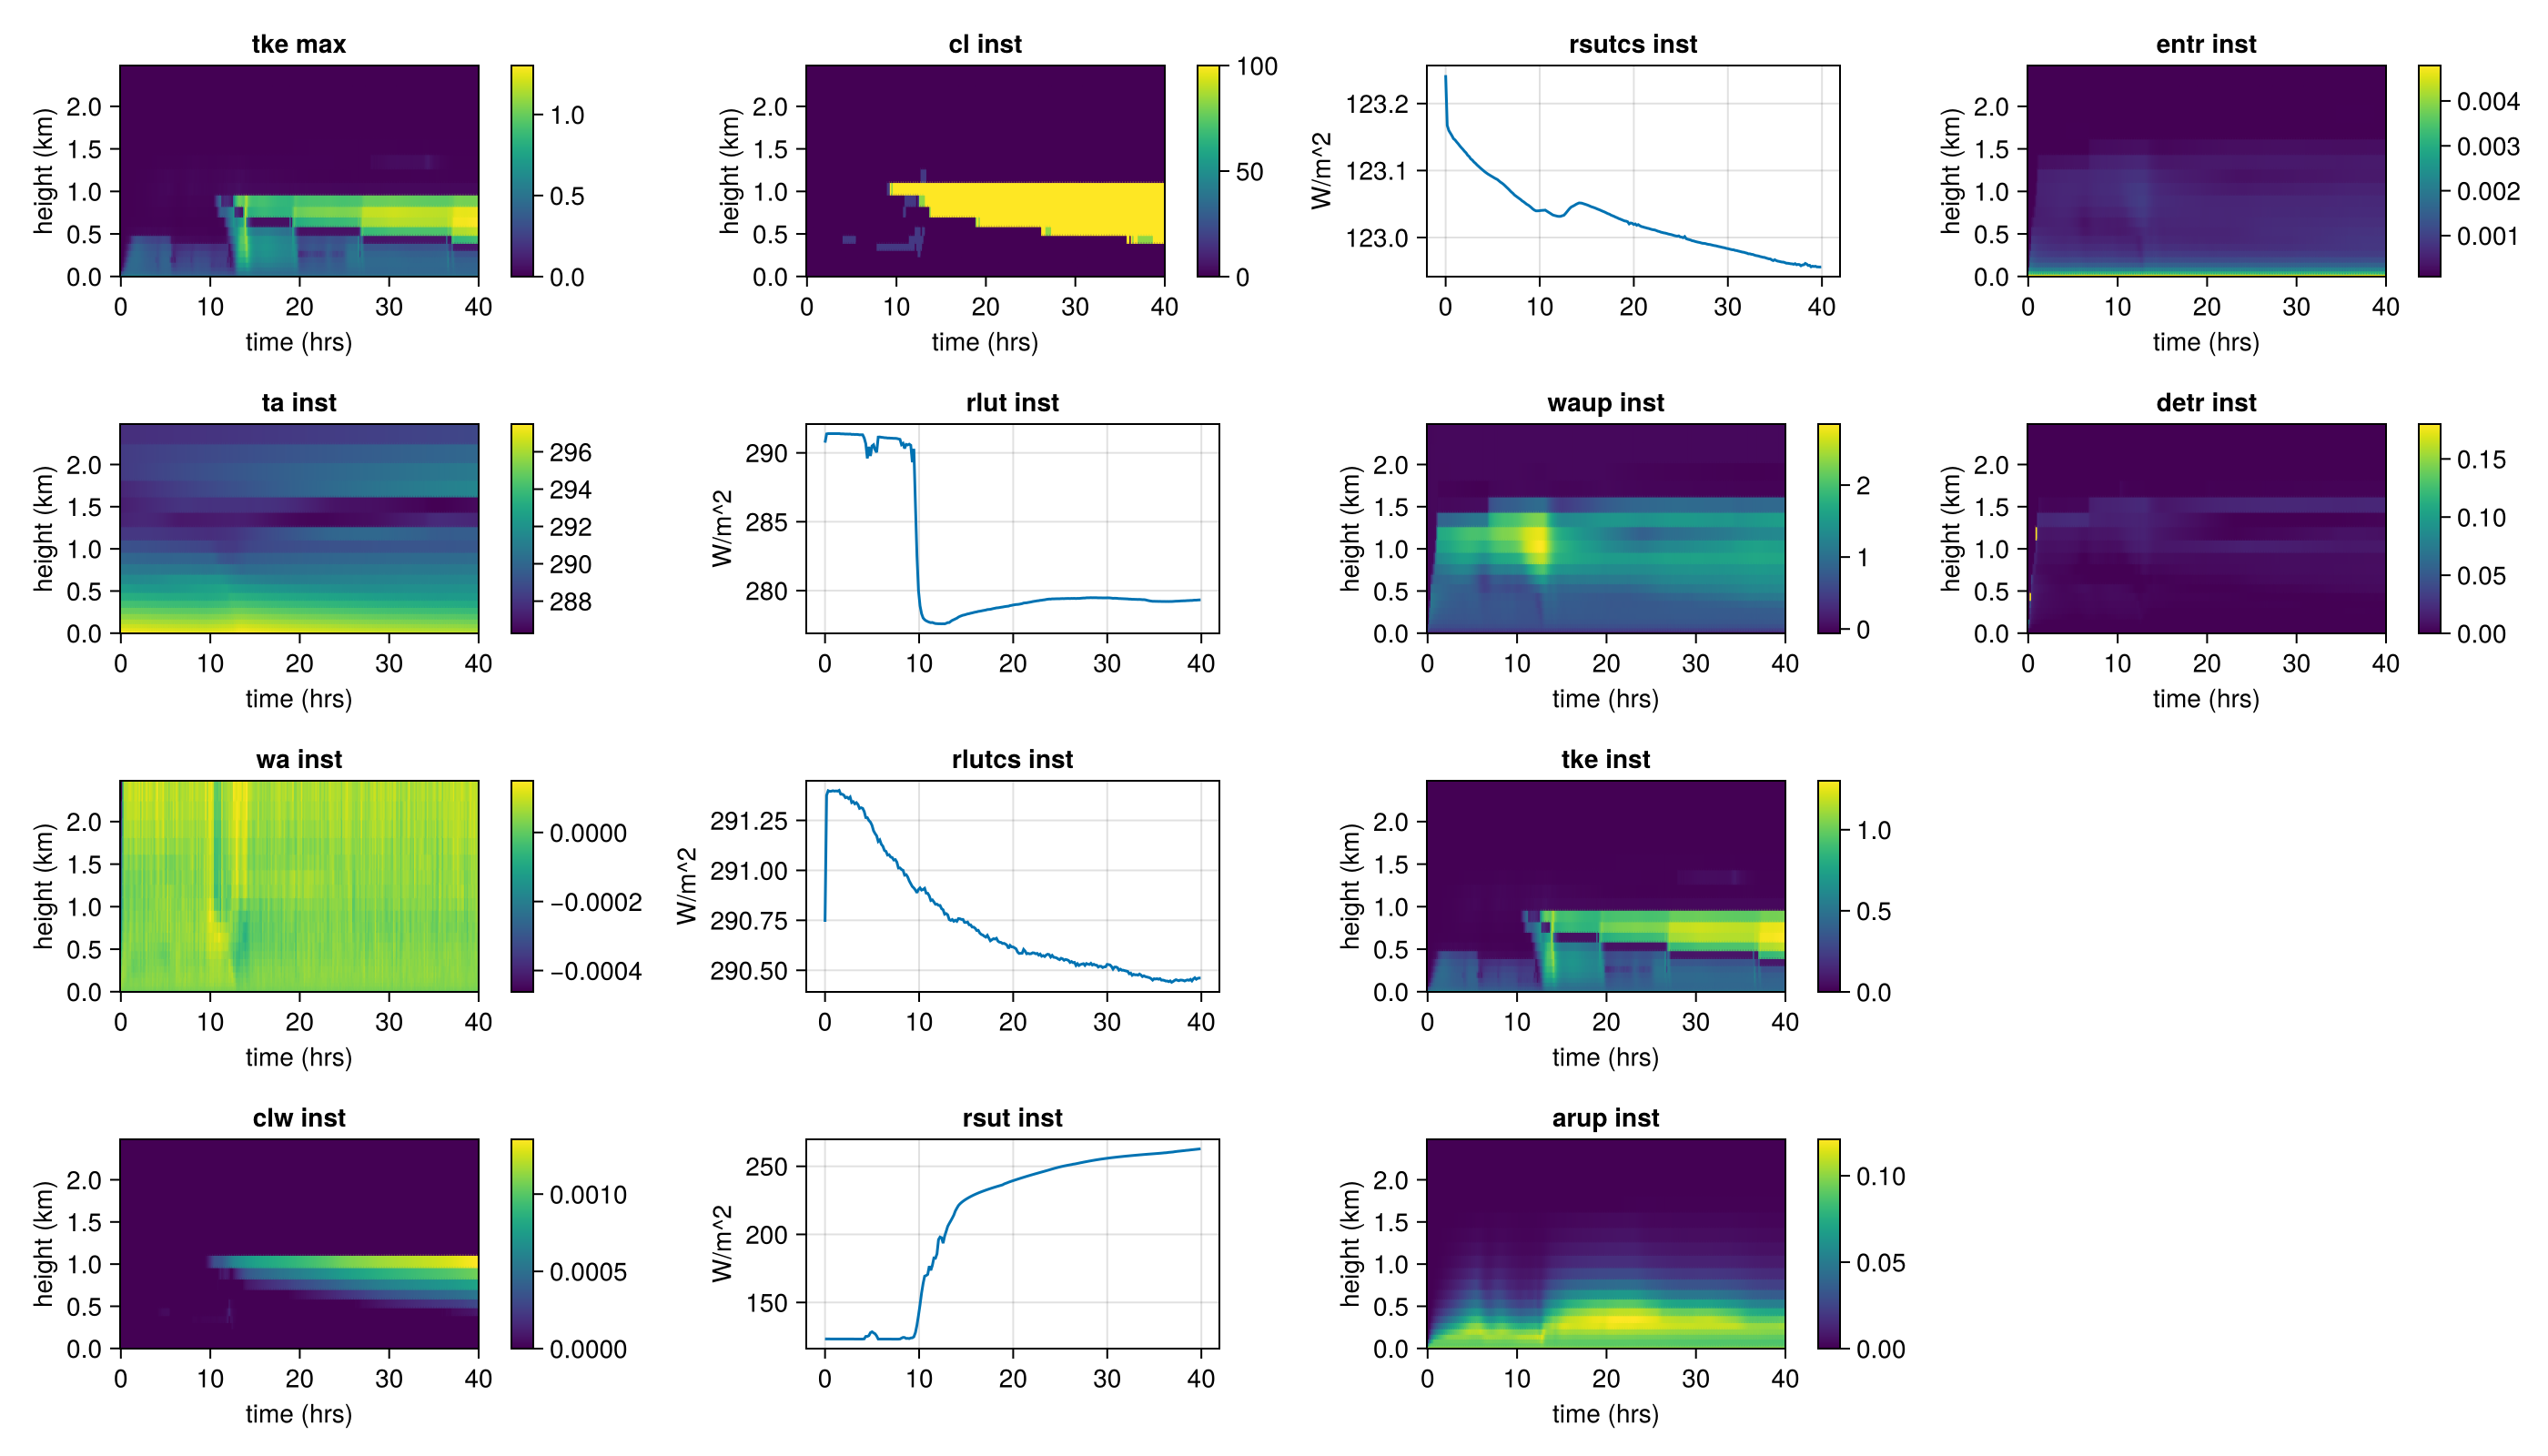

In [151]:
plot_defaults(joinpath("output", "gcm_driven_scm", "iteration_002", "member_006","output_active"))

## Dev function to generate profiles

In [28]:
import YAML
import ClimaAnalysis: SimDir, get, slice, average_xy, available_vars, window, average_time

In [19]:
pwd()
simpath = joinpath("output", "local_calibration", "output_active")
simdir = SimDir(simpath)
variables = collect(available_vars(simdir))

46-element Vector{Any}:
 "rhoa"
 "taen"
 "pr"
 "waup"
 "wa"
 "ua"
 "cli"
 "thetaaup"
 "hussfc"
 "tke"
 ⋮
 "huren"
 "clw"
 "va"
 "husen"
 "pfull"
 "rlutcs"
 "clien"
 "hurup"
 "waen"

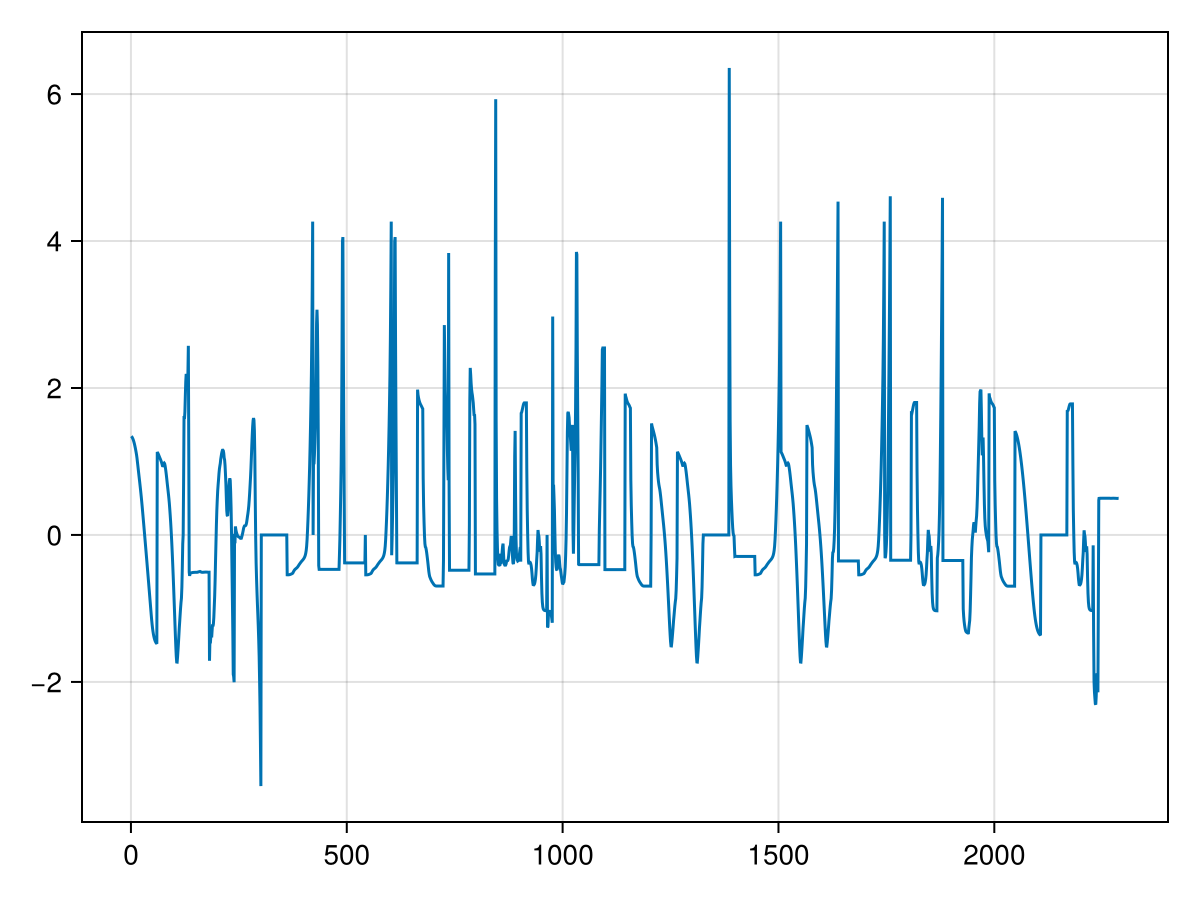

In [57]:
fieldnames(typeof(simdir))
# read in experiment config 
experiment_config = YAML.load_file("experiment_config.yml")

# # compute the window time average
# da_var = get(simdir; short_name = "ta", reduction = "inst")
# da_slice = window(da_var, "time", left = experiment_config["g_t_start_sec"], right = experiment_config["g_t_end_sec"])
# da_slice = average_time(da_slice)
# da_slice.data[1, 1, :]


function extract_profile(simdir, var, experiment_config)
    da_var = get(simdir; short_name = var, reduction = "inst")
    da_slice = window(da_var, "time", left = experiment_config["g_t_start_sec"], right = experiment_config["g_t_end_sec"])
    da_slice = average_time(da_slice)
    return da_slice.data[1, 1, :]
end

# function to extract all profiles from a simulation directory
function extract_profiles(simdir, experiment_config)
    profiles = Dict()
    for variable in available_vars(simdir)
        profile = extract_profile(simdir, variable, experiment_config)
        profiles[variable] = Dict("profile" => profile, "μ" => mean(profile), "σ²" => var(profile))
    end
    return profiles
end

profiles = extract_profiles(simdir, experiment_config)

# combine profiles into a single vector, normalizing by mean and variance 
function combine_profiles(profiles)
    profile_vec = []
    for variable in available_vars(simdir)
        profile = profiles[variable]["profile"]
        μ = profiles[variable]["μ"]
        σ² = profiles[variable]["σ²"]
        profile = σ² > 0 ? (profile .- μ) ./ sqrt(σ²) : profile .- μ
        append!(profile_vec, profile)
    end
    return profile_vec
end
combined = combine_profiles(profiles)
lines(combined)

In [154]:
get(simdir; short_name = "hussfc", reduction = "inst").data[:, 1, 1]

250-element Vector{Float32}:
 0.019470964
 0.019483589
 0.019479841
 0.01947208
 0.019468542
 0.019466452
 0.019464655
 0.019463157
 0.019461798
 0.019460365
 ⋮
 0.019006498
 0.01900745
 0.019008443
 0.019009441
 0.019010434
 0.019011606
 0.019012583
 0.019013023
 0.019013897

In [162]:
tapio_loss_vars = ["ta", "thetaa", "ha", "rhoa", 
                    "hur", "hus", "cl", "clw",
                     "hussfc", 
                     "rlut", "rlutcs", "rsut", "rsutcs"]
# extract all profiles for all simulations with fixed relative error
function combine_profiles(simdir, experiment_config; vars = tapio_loss_vars)
    profiles = extract_profiles(simdir, experiment_config, vars = vars)
    profile_vec = Float64[]
    var_vec = Float64[]
    for variable in vars
        profile = profiles[variable]["profile"]
        μ = profiles[variable]["μ"]
        σ² = profiles[variable]["σ²"]

        #profile = σ² > 0 ? (profile .- μ) ./ sqrt(σ²) : profile .- μ
        if variable in ["rlut", "rlutcs", "rsut", "rsutcs"]
            append!(profile_vec, profile) 
            append!(var_vec, 1) # typical error of 1 W/m^2 for radiative variables
        elseif variable in ["hussfc"]
            append!(profile_vec, profile)
            append!(var_vec, 1e-4) 
        else
            append!(profile_vec, profile)
            append!(var_vec, repeat([σ²], length(profile))) # 1% relative error
        end
    end
    return profile_vec, var_vec
end

function extract_profiles(simdir, experiment_config; vars = tapio_loss_vars)
    profiles = Dict()
    for variable in vars
        profile = extract_profile(simdir, variable, experiment_config)
        # add artificial noise to the profile
        profile = profile .* (1 .+ randn(length(profile)) ./ 100)
        profiles[variable] = Dict("profile" => profile, "μ" => mean(profile), "σ²" => var(profile))
    end
    return profiles
end


cat_profile, noise = combine_profiles(simdir, experiment_config, vars = tapio_loss_vars)

([295.15331491275987, 295.8026345634686, 293.92688195686264, 295.7659023917306, 296.9248705965124, 288.7265182190337, 288.60262297557875, 295.71123071859495, 284.4062314049279, 289.7298024658303  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.019324234414205294, 280.1991503821803, 291.7951603200061, 273.7154865414994, 121.92719559874487], [1074.6132773556608, 1074.6132773556608, 1074.6132773556608, 1074.6132773556608, 1074.6132773556608, 1074.6132773556608, 1074.6132773556608, 1074.6132773556608, 1074.6132773556608, 1074.6132773556608  …  1.39039225472809e-7, 1.39039225472809e-7, 1.39039225472809e-7, 1.39039225472809e-7, 1.39039225472809e-7, 0.0001, 1.0, 1.0, 1.0, 1.0])

In [163]:
noise

485-element Vector{Float64}:
 1074.6132773556608
 1074.6132773556608
 1074.6132773556608
 1074.6132773556608
 1074.6132773556608
 1074.6132773556608
 1074.6132773556608
 1074.6132773556608
 1074.6132773556608
 1074.6132773556608
    ⋮
    1.39039225472809e-7
    1.39039225472809e-7
    1.39039225472809e-7
    1.39039225472809e-7
    0.0001
    1.0
    1.0
    1.0
    1.0

In [164]:
Diagonal(noise)

485×485 Diagonal{Float64, Vector{Float64}}:
 1074.61      ⋅        ⋅        ⋅        ⋅    …   ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅    1074.61      ⋅        ⋅        ⋅        ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅        ⋅    1074.61      ⋅        ⋅        ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅        ⋅        ⋅    1074.61      ⋅        ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅        ⋅        ⋅        ⋅    1074.61      ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅        ⋅        ⋅        ⋅        ⋅    …   ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅        ⋅        ⋅        ⋅        ⋅        ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅        ⋅        ⋅        ⋅        ⋅        ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅        ⋅        ⋅        ⋅        ⋅        ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅        ⋅        ⋅        ⋅        ⋅        ⋅       ⋅    ⋅    ⋅    ⋅ 
    ⋮                                         ⋱  ⋮                      
     ⋅        ⋅        ⋅        ⋅        ⋅        ⋅       ⋅    ⋅    ⋅    ⋅ 
     ⋅        ⋅        ⋅        ⋅        ⋅     

In [156]:
sum(isnan.(noise))

0

In [165]:
# save 
JLD2.save_object("observations.jld2", cat_profile)
JLD2.save_object("obs_noise_cov.jld2", Diagonal(noise))

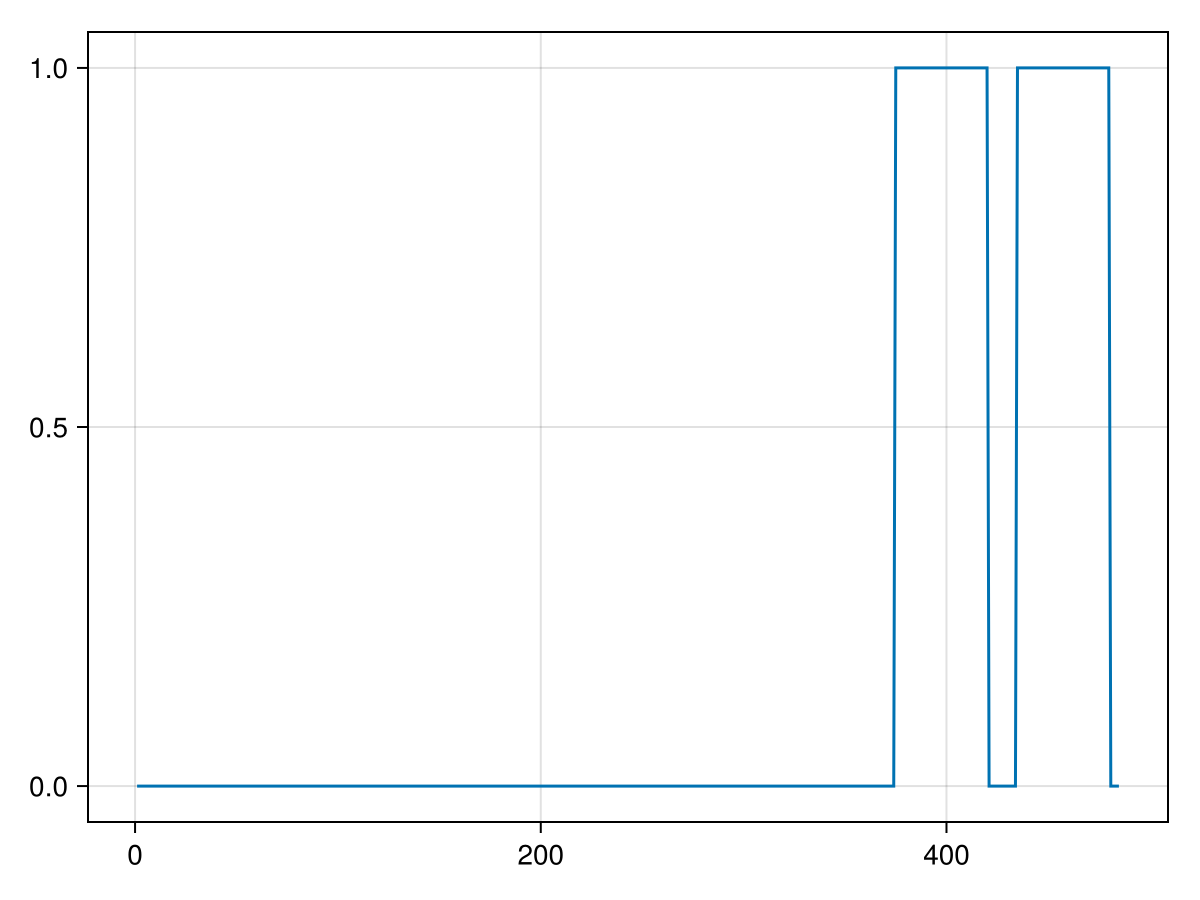

In [138]:
lines(cat_profile .==0)

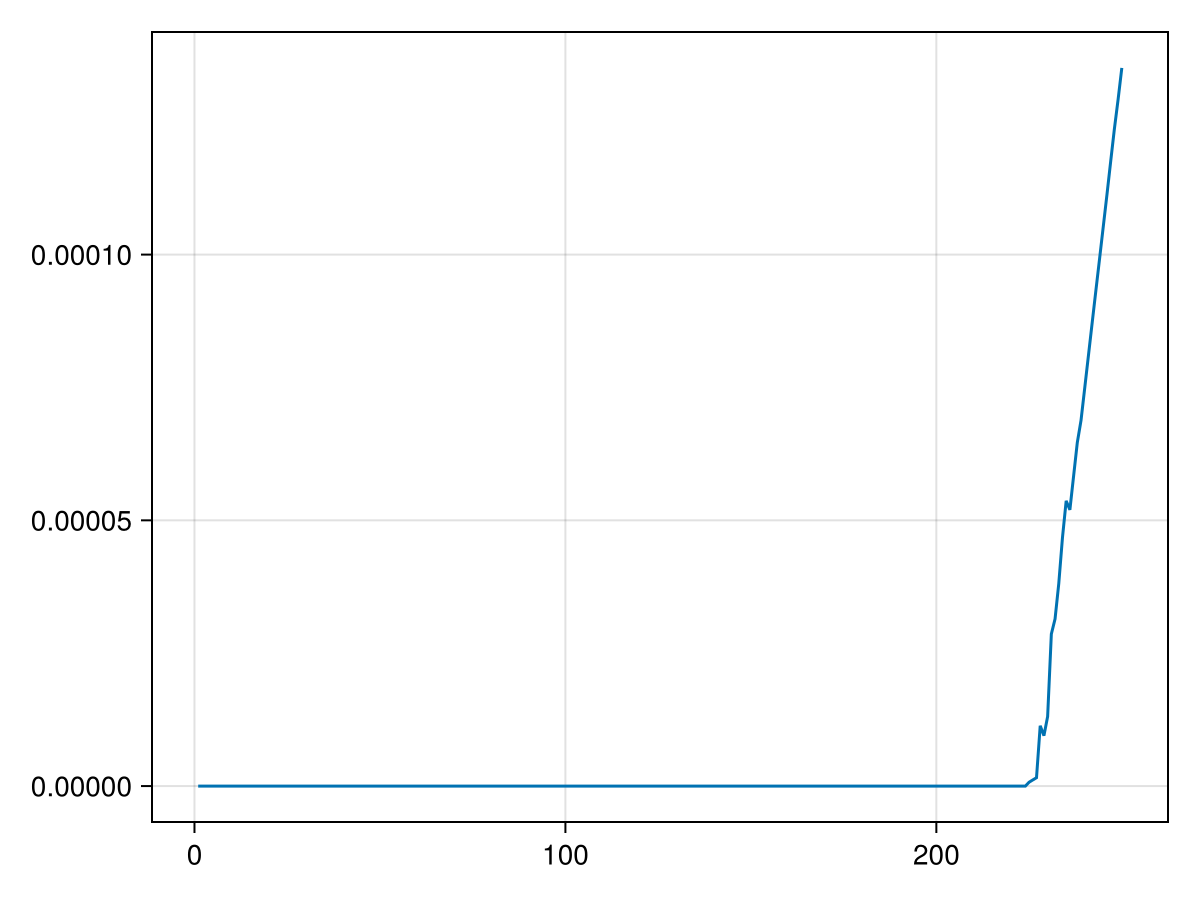

In [112]:
lines(get(simdir; short_name = "clw", reduction = "inst").data[:, 1, 1,1])

In [107]:
tapio_loss_vars

13-element Vector{String}:
 "ta"
 "thetaa"
 "ha"
 "rhoa"
 "hur"
 "hus"
 "cl"
 "clw"
 "hussfc"
 "rlut"
 "rlutcs"
 "rsut"
 "rsutcs"

In [ ]:
# save combined profiles to a file
JLD2.save("combined_profiles.jld2", combined)

In [59]:
# mean(extract_profile(simdir, "ta", experiment_config))
profiles["rhoa"]

Dict{String, Any} with 3 entries:
  "profile" => Float32[1.18525, 1.1822, 1.17806, 1.1731, 1.1671, 1.16, 1.15172,…
  "μ"       => 0.62349
  "σ²"      => 0.174685

In [166]:
pwd()

"/Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration"

In [171]:
simdir = SimDir(joinpath("output", "local_calibration", "iteration_000", "member_001","output_active"))

get(simdir; short_name = "ta", reduction = "inst").dims["z"]

60-element Vector{Float32}:
    15.0
    49.13878
    91.66503
   142.80383
   202.79102
   271.87396
   350.3122
   438.37814
   536.3576
   644.5504
     ⋮
 22572.047
 23997.504
 25534.7
 27200.482
 29016.207
 31009.55
 33217.312
 35690.04
 38500.0

In [ ]:
[thetaa, hur, hus, cl, clw, cli]
[rlut, rlutcs, rsut, rsutcs]
# integrals of cl, clw, cli try


In [173]:
pwd()

"/Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration"

In [174]:
# examine eki files
eki = JLD2.load_object("output/local_calibration/iteration_003/eki_file.jld2")
eki

EnsembleKalmanProcesses.EnsembleKalmanProcess{Float64, Int64, EnsembleKalmanProcesses.Inversion, EnsembleKalmanProcesses.DefaultScheduler{Float64}, EnsembleKalmanProcesses.DefaultAccelerator}(EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}[EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-1.9067828240772768 -2.0329857339977924 … -1.8364840894918002 -2.0277081424839087; 0.14555099867397547 0.11419519730477608 … 0.10907643207586122 0.083684820060044; … ; -9.226732797084804 -9.198773076822519 … -9.091094849581513 -9.220298140164312; -1.5630794342706944 -1.560008246576264 … -1.509050359332279 -1.5492521486676536]), EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-1.8032733567955133 -1.9013981871605183 … -1.7014646876524795 -1.8461023484802628; 0.21092911915398233 0.2065404238101448 … 0.182779926620468 0.21553806348757876; … ; -9.311725970536294 -9.303630373735178 … -9.195090387408772 -9.288235402150404; -1.5238050331597812 -1.5170278589089146 … -1

In [175]:
fieldnames(typeof(eki))

(:u, :observation_series, :N_ens, :g, :err, :scheduler, :accelerator, :Δt, :process, :rng, :failure_handler, :localizer, :verbose)

4-element Vector{EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}}:
 EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-1.9067828240772768 -2.0329857339977924 … -1.8364840894918002 -2.0277081424839087; 0.14555099867397547 0.11419519730477608 … 0.10907643207586122 0.083684820060044; … ; -9.226732797084804 -9.198773076822519 … -9.091094849581513 -9.220298140164312; -1.5630794342706944 -1.560008246576264 … -1.509050359332279 -1.5492521486676536])
 EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-1.8032733567955133 -1.9013981871605183 … -1.7014646876524795 -1.8461023484802628; 0.21092911915398233 0.2065404238101448 … 0.182779926620468 0.21553806348757876; … ; -9.311725970536294 -9.303630373735178 … -9.195090387408772 -9.288235402150404; -1.5238050331597812 -1.5170278589089146 … -1.4619519268190193 -1.4922675672231223])
 EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-1.8304399693115558 -1.9275575359295651 … -1.738742823570002 -1.8758